# Interproduct tweet analysis
In this analysis we attempt to compare tweets on different tobocco product groups with each other. Date range 1st April 2017 to 29th March 2018. The purpose of the analysis is to study if in the last 12 months, there has been changes in the number of conversions on each product.

A tweet by a user on product P is considered a conversation on P. We wish to find how the products talked about by users change.

In [1]:
import datetime
import functools as ft
import glob
import itertools as it
import os
import pickle
from types import SimpleNamespace

import bokeh.plotting as bplt
import bokeh.models as bmodels
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

bplt.output_notebook()

CURRENT_DIR = os.path.abspath(os.curdir)
DATA_PICKLE_DIR = os.path.join(CURRENT_DIR, 'Data\\Pickles\\')

%matplotlib inline

Loading BokehJS ...

## Data
The analysis is performed on tweets from 1st April 2017 to 29th March 2018. We extracted all **english** tweets ***(discarding re-tweets)*** containing the following keywords (per product group):
* __Swisher__: swisher, swisher sweets, swishersweets, swisherartistproject, swisherartistgrant, swisheratl
* __Hookah__: hookah, shees, seesh
* __E-Cigs__: e-cig, ecig, e-cigs, ecigs, e-cigarette, ecigarette, e-cigarettes, ecigarettes
* __Vape__: vape, vaper, vaping, vapes, vapers
* __Cigarette__: cigarette, cigarettes, marlboro

A tweet was selected if it contained any of the above words or contained a hastag containing any keyword as part of it. This resulted in an average of 400K tweets per month.

Due to the parallelizable nature of the preprocessing, and the huge amount of data we needed to process, all pre-processing was done seperately. The pre-processing scripts can be found int the Data folder (see ReadMe.md for instructions).

In [ ]:
def load_data(data_dir):
    data = []
    for pickle_file in glob.glob(os.path.join(DATA_PICKLE_DIR, 'Tweets-*.csv.pickle')):
        month, year = map(int, os.path.basename(pickle_file).split('.')[0].split('-')[1:3])
        date = datetime.date(year, month, 1)
        with open(pickle_file, 'rb') as file_handle:
            df = pickle.load(file_handle)
        data.append(SimpleNamespace(df=df, date=date, date_label=date.strftime('%b %Y')))
    data.sort(key=lambda x: x.date)
    return data

data = load_data(DATA_PICKLE_DIR)

For the purpose of the analysis, we will use the months as timeframes. This is a natural division of our data. Below is the number of tweets per month:

In [3]:
def tweet_hist_monthly(data):
    ds = bplt.ColumnDataSource(data=dict(
        month=[datum.date_label for datum in data],
        count=[datum.df.shape[0] for datum in data]
    ))
    hover = bmodels.HoverTool(tooltips=[
        ('month', '@month'),
        ('num tweets', '@count')
    ])
    fig = bplt.figure(plot_width=900, plot_height=600, x_range=ds.data['month'],
                      x_axis_label='Month', y_axis_label='Number of Tweets', tools=[hover],
                      title='Num Tweets vs Month')
    fig.vbar(x='month', top='count', bottom=0, width=0.5, source=ds)
    return fig

bplt.show(tweet_hist_monthly(data))

This shows that number of tweets per month remains roughly about the same, except for in December in which there was a drastic fall in number of tweets.

Similarly let's have a look at the number of users who tweeted at each month.

In [4]:
def user_hist_monthly(data):
    ds = bplt.ColumnDataSource(data=dict(
        month=[datum.date_label for datum in data],
        count=[len(datum.df.UserId.unique()) for datum in data]
    ))
    hover = bmodels.HoverTool(tooltips=[
        ('month', '@month'),
        ('num users', '@count')
    ])
    fig = bplt.figure(plot_width=900, plot_height=600, x_range=ds.data['month'],
                      x_axis_label='Month', y_axis_label='Number of Users', tools=[hover],
                      title='Num Users vs Month')
    fig.vbar(x='month', top='count', bottom=0, width=0.5, source=ds)
    return fig

bplt.show(user_hist_monthly(data))

This matches the tweets in the distribution.

Lastly, let's look at the distribution of number of tweets per user for each month.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B277200B8>,
      dtype=object)

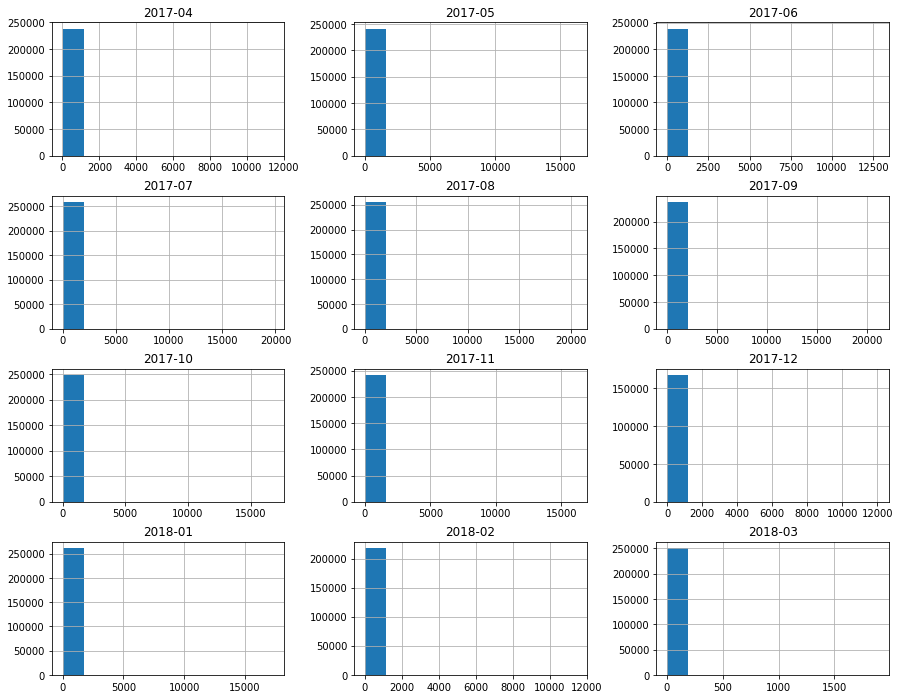

In [5]:
def user_tweet_distr(data):
    monthly_tweet_num_hist = [(datum.df.groupby('UserId').size(),\
                               datum.date) for datum in data]
    df = pd.concat([pd.Series(x[0], name=x[1].strftime('%Y-%m')) for x in monthly_tweet_num_hist], axis=1)
    return df.hist(figsize=(15, 12))

user_tweet_distr(data)

In the above plots the x-axis = number of tweets. The y-axis shows the number of users.

Almost 80% of the users in each month have only 1 tweet. These indicate one off tweets and may include paid promotions to make some hashtags trending. This might be a problem in the future, in that case, we will discard all users with less than 2 tweets and re-run the analysis.

## Product group conversions
In order to see how conversations change over time, we will need to divide our tweets into product groups. Each tweet is assigned to a product group if it contains any one of the keywords corresponding to the group.

In [2]:
def data_with_product_groups(data, group_keywords):
    pickle_file_name = os.path.join(DATA_PICKLE_DIR, 'ProductGroupedDFs.pickle')
    if not os.path.exists(pickle_file_name):
        print(f'Cached pickle not found at {pickle_file_name}. Creating from scratch.')
        for datum in data:
            print(f'Adding groups to {datum.date_label}:')
            for group, keywords in group_keywords.items():
                print(f'\tAdding group {group} ')
                datum.df[group] = datum.df.apply(
                    lambda x: len(keywords.intersection(x.NormalizedText + x.NormalizedTextLemmatized)) > 0 or\
                        any(word in hashtag for word in keywords for hashtag in x.HashTags),
                    axis=1)
        with open(pickle_file_name, 'wb') as file_handle:
            pickle.dump(data, file_handle)
    else:
        print(f'Loading cached pickle found at {pickle_file_name}.')
        with open(pickle_file_name, 'rb') as file_handle:
            data = pickle.load(file_handle)
    return data

product_groups = {
    'swisher': {'swisher', 'swisher sweets', 'swishersweets', 'swisherartistproject', 'swisherartistgrant', 'swisheratl'},
    'hookah': {'hookah', 'shees', 'seesh'},
    'ecigs': {'e-cig', 'ecig', 'e-cigs', 'ecigs', 'e-cigarette', 'ecigarette', 'e-cigarettes', 'ecigarettes'},
    'vape': {'vape', 'vaper', 'vaping', 'vapes', 'vapers'},
    'cigarette': {'cigarette', 'cigarettes', 'marlboro'}
}

# Uncomment below line if data was not initialized, and we know that the grouped data was cached.
data = None
data = data_with_product_groups(data, product_groups)

We can now plot the tweets per month graph for each group.

In [4]:
def tweet_group_hist_monthly(data):
    ds = bplt.ColumnDataSource(data=dict(
        month=[datum.date_label for datum in data]
    ))
    hover_rules = [('month', '@month')]
    for group in product_groups:
        ds.add([datum.df[datum.df[group]].shape[0] for datum in data], name=group)
        hover_rules.append((f'num {group} tweets:', f'@{group}'))

    hover = bmodels.HoverTool(tooltips=hover_rules)
    fig = bplt.figure(plot_width=900, plot_height=600, x_range=ds.data['month'],
                      x_axis_label='Month', y_axis_label='Number of Tweets', tools=[hover],
                      title='Num Tweets per product group vs Month')
    for i, group in enumerate(product_groups):
        color = bmodels.palettes.Category10[5][i]
        fig.line(x='month', y=group, color=color, source=ds, legend=f' {group}')
        fig.circle(x='month', y=group, size=5, color=color, source=ds)
    return fig

bplt.show(tweet_group_hist_monthly(data))

Similarly we plot the number of users per month per product group.

In [5]:
def user_group_hist_monthly(data):
    ds = bplt.ColumnDataSource(data=dict(
        month=[datum.date_label for datum in data]
    ))
    hover_rules = [('month', '@month')]
    for group in product_groups:
        ds.add([len(datum.df[datum.df[group]].UserId.unique()) for datum in data], name=group)
        hover_rules.append((f'num {group} users:', f'@{group}'))

    hover = bmodels.HoverTool(tooltips=hover_rules)
    fig = bplt.figure(plot_width=900, plot_height=600, x_range=ds.data['month'],
                      x_axis_label='Month', y_axis_label='Number of Users', tools=[hover],
                      title='Num Users per product group vs Month')
    for i, group in enumerate(product_groups):
        color = bmodels.palettes.Category10[5][i]
        fig.line(x='month', y=group, color=color, source=ds, legend=f' {group}')
        fig.circle(x='month', y=group, size=5, color=color, source=ds)
    return fig

bplt.show(user_group_hist_monthly(data))

### Defining conversions
As we have seen a user may be associated with multiple product groups. In order to define a conversion we need to classify a user into one unique product group. There are two ways to classify a user:
1. **Most frequent product**: A user is classified into product group *A* if the total number of tweets by the user on product group A is greater than the number of tweets on any other group.
2. **Only product**: A user is classified into product group *A* if he only talks about that product group in a month.

A conversion happens when the user's classification changes between months.

In [44]:
def classify_users(data):
    classified_users = []
    for datum in data:
        product_count = datum.df.groupby('UserId')[list(product_groups.keys())].sum()
        product_count['classification'] = product_count.idxmax(axis=1)
        # User is a most frequent user if only 1 of the products has the max tweet count.
        product_count['select_freq'] = product_count.apply(
            lambda x: sum(x[group] == x[x.classification] for group in product_groups) == 1,
            axis=1)
        # User talks about only one product if only 1 product has tweets
        product_count['select_only'] = product_count.apply(
            lambda x: sum(x[group] != 0 for group in product_groups) == 1,
            axis=1)
        classified_users.append(SimpleNamespace(df=product_count, date=datum.date, date_label=datum.date_label))
    return classified_users

classified_users = classify_users(data)

In [46]:
classified_users[0].df.head()

,swisher,hookah,ecigs,vape,cigarette,classification,select_freq,select_only
UserId,,,,,,,,
521,0.0,0.0,0.0,1.0,0.0,vape,True,True
528,0.0,0.0,0.0,1.0,0.0,vape,True,True
586,0.0,0.0,0.0,1.0,0.0,vape,True,True
767,0.0,0.0,0.0,6.0,2.0,vape,True,False
1084,0.0,0.0,0.0,1.0,0.0,vape,True,True


In the above table the `classification` column shows the classification of the user. This classification is valid according to the *Most frequent product* rule if `select_freq` is `True`; and valid for the *Only product* rule if `select_only` is `True`.

Now we can create a Sankey diagram to show the conversions taking place each month. We use an online tool http://sankeymatic.com/build/ to create a Sanke diagram. The input to the tool is generated below and stored in the specified files.

Two files are created for each classification type.

In [140]:
def create_conversions_sankey_file(user_classes, most_freq_file, only_product_file, remaining=True):
    conversion_matrix = [[], []]
    with open(most_freq_file, 'w', encoding='utf-8') as file_handle_1,\
        open(only_product_file, 'w', encoding='utf-8') as file_handle_2:
        for source_month, target_month in zip(user_classes, user_classes[1:]):
            source_users, target_users = [{}, {}], [{}, {}]
            for group in product_groups:
                s_users = source_month.df[source_month.df.classification == group]
                source_users[0][group] = s_users[s_users.select_freq].index
                source_users[1][group] = s_users[s_users.select_only].index
                t_users = target_month.df[target_month.df.classification == group]
                target_users[0][group] = t_users[t_users.select_freq].index
                target_users[1][group] = t_users[t_users.select_only].index
            intersections_1 = np.zeros((len(product_groups), len(product_groups)))
            intersections_2 = np.zeros((len(product_groups), len(product_groups)))
            for i, s_group in enumerate(product_groups):
                for j, t_group in enumerate(product_groups):
                    intersect_1 = np.intersect1d(source_users[0][s_group], target_users[0][t_group])
                    intersect_2 = np.intersect1d(source_users[1][s_group], target_users[1][t_group])
                    intersections_1[i][j] = len(intersect_1)
                    intersections_2[i][j] = len(intersect_2)
                    if len(intersect_1) > 0:
                        file_handle_1.write(f'{s_group} {source_month.date.strftime("%m/%y")} [{len(intersect_1)}] {t_group} {target_month.date.strftime("%m/%y")}\n')
                        file_handle_2.write(f'{s_group} {source_month.date.strftime("%m/%y")} [{len(intersect_2)}] {t_group} {target_month.date.strftime("%m/%y")}\n')
            s_total_1 = np.fromiter((len(source_users[0][s_group]) for s_group in product_groups), dtype=int)
            s_total_2 = np.fromiter((len(source_users[1][s_group]) for s_group in product_groups), dtype=int)
            inactive_1 = s_total_1 - intersections_1.sum(axis=1)
            inactive_2 = s_total_2 - intersections_2.sum(axis=1)
            for i, s_group in enumerate(product_groups):
                if inactive_1[i] > 0 and remaining:
                    file_handle_1.write(f'{s_group} {source_month.date.strftime("%m/%y")} [{inactive_1[i]}] inactive users {target_month.date.strftime("%m/%y")}\n')
                    file_handle_2.write(f'{s_group} {source_month.date.strftime("%m/%y")} [{inactive_2[i]}] inactive users {target_month.date.strftime("%m/%y")}\n')
            t_total_1 = np.fromiter((len(target_users[0][t_group]) for t_group in product_groups), dtype=int)
            t_total_2 = np.fromiter((len(target_users[1][t_group]) for t_group in product_groups), dtype=int)
            new_1 = t_total_1 - intersections_1.sum(axis=0)
            new_2 = t_total_1 - intersections_1.sum(axis=1)
            for i, t_group in enumerate(product_groups):
                if new_1[i] > 0 and remaining:
                    file_handle_1.write(f'new users {target_month.date.strftime("%m/%y")} [{new_1[i]}] {t_group} {target_month.date.strftime("%m/%y")}\n')
                    file_handle_2.write(f'new users {target_month.date.strftime("%m/%y")} [{new_2[i]}] {t_group} {target_month.date.strftime("%m/%y")}\n')
            inactive_1 = inactive_1.reshape(inactive_1.shape[0], 1)
            inactive_2 = inactive_2.reshape(inactive_2.shape[0], 1)
            new_1 = np.append(new_1, 0).reshape(1, new_1.shape[0] + 1)
            new_2 = np.append(new_2, 0).reshape(1, new_2.shape[0] + 1)
            conversion_matrix[0].append(np.append(np.append(intersections_1, inactive_1, axis=1), new_1, axis=0))
            conversion_matrix[1].append(np.append(np.append(intersections_2, inactive_2, axis=1),
                                                  new_2, axis=0))
    return conversion_matrix

create_conversions_sankey_file(classified_users,
                               os.path.join(CURRENT_DIR, 'Assets\\sankey1.txt'),
                               os.path.join(CURRENT_DIR, 'Assets\\sankey2.txt'), remaining=False)
conversion_matrix = create_conversions_sankey_file(classified_users,
                               os.path.join(CURRENT_DIR, 'Assets\\sankey1_with_remaining.txt'),
                               os.path.join(CURRENT_DIR, 'Assets\\sankey2_with_remaining.txt'))

Majority of the users are new users who don't continue tweeting about any product the following month. This makes the visualization rather clumsy, so below is the visualization for the conversions by ignoring new users.

#### Conversions for *most frequent product* classification

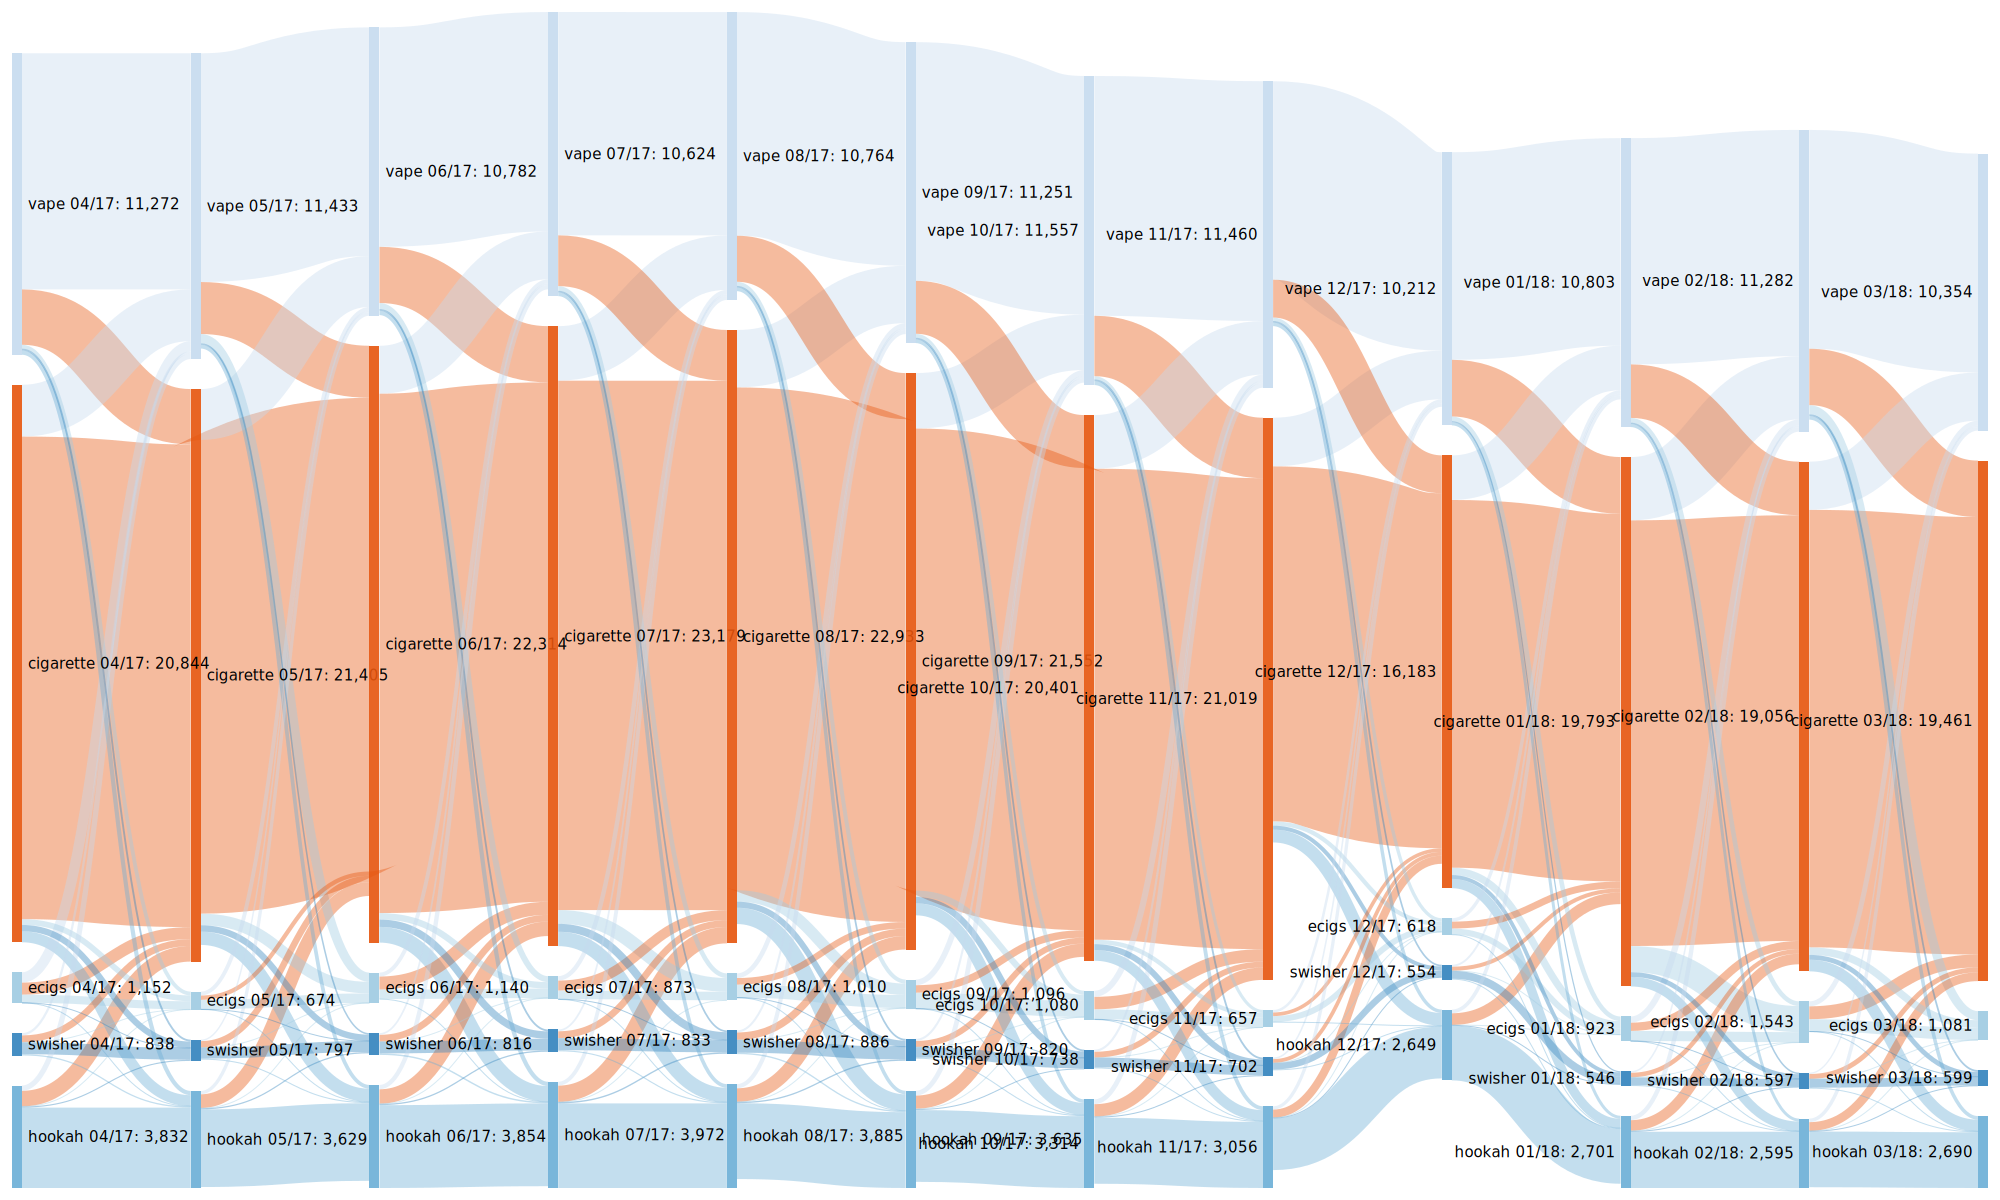

In [111]:
from IPython.display import SVG, display
display(SVG(filename=os.path.join(CURRENT_DIR, 'Assets\\most_frequent_classification.svg')))

#### Conversions for only product classification

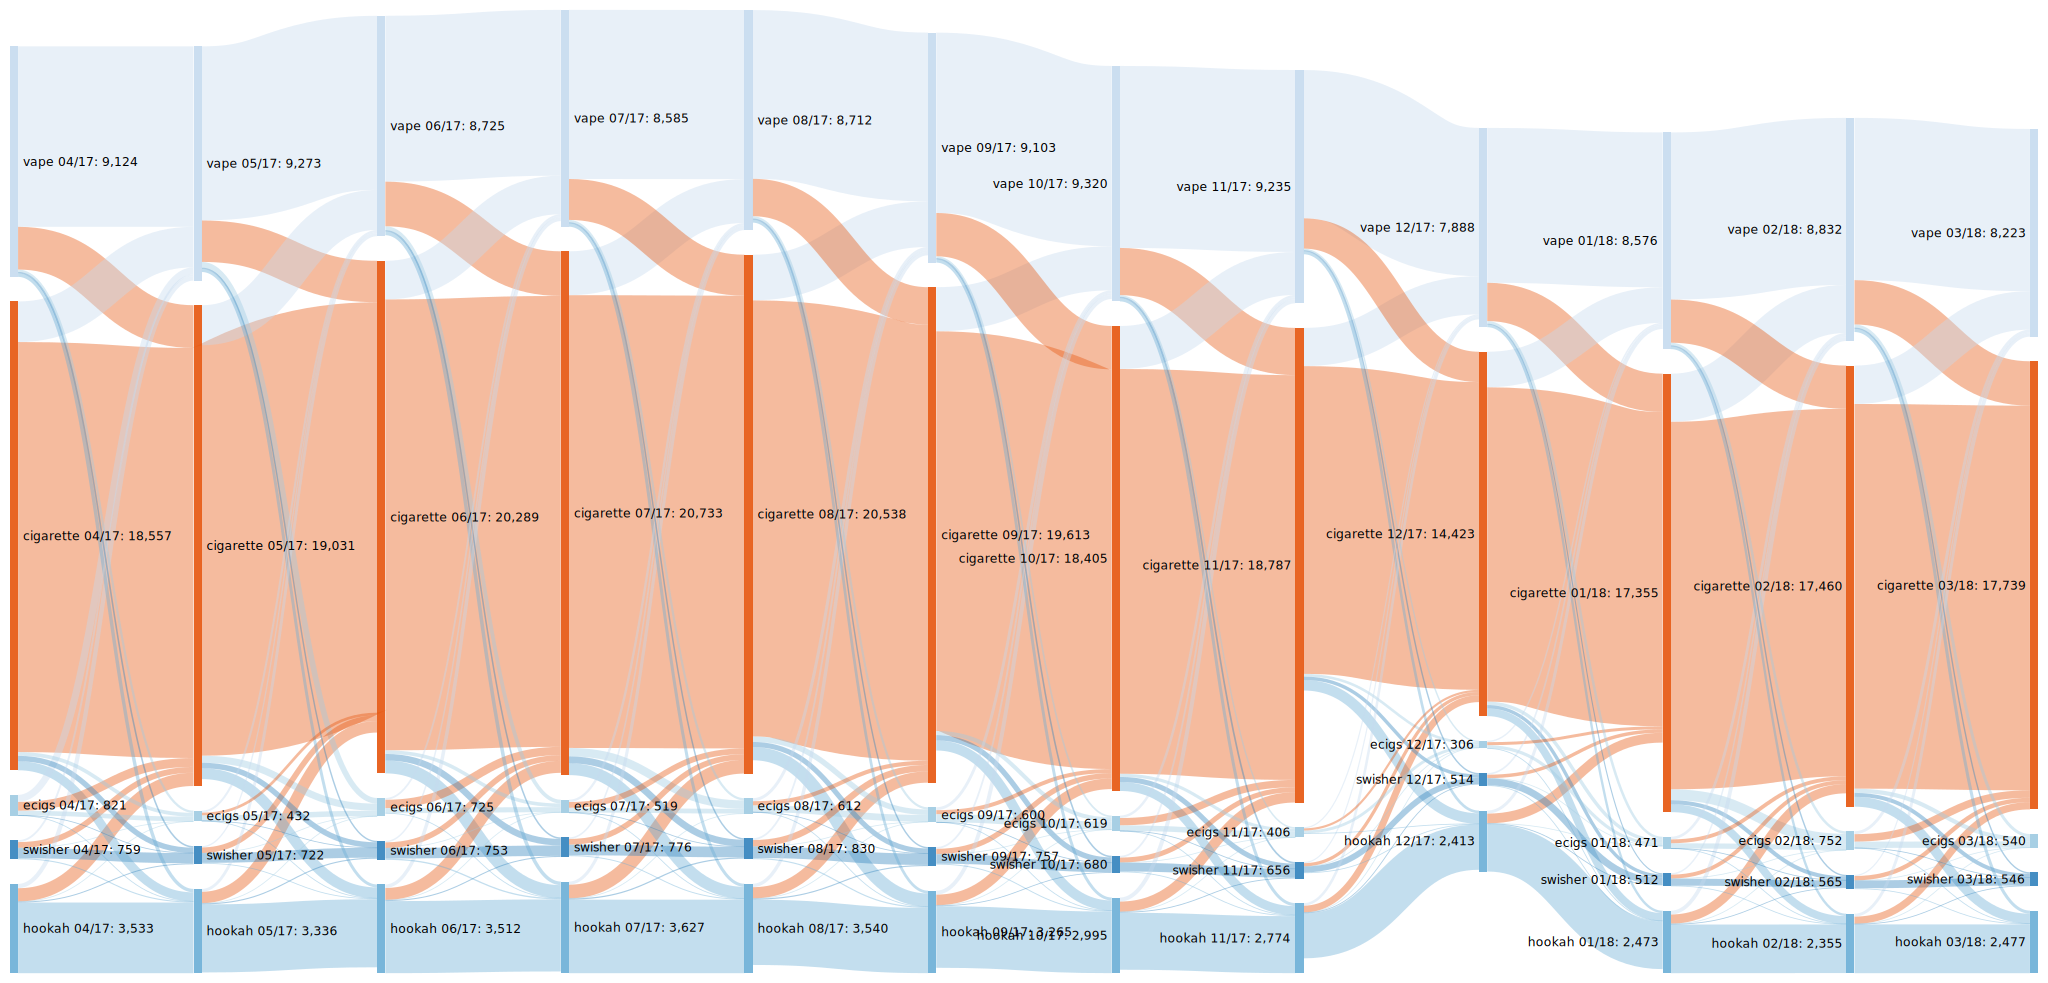

In [112]:
display(SVG(filename=os.path.join(CURRENT_DIR, 'Assets\\only_product.svg')))

#### Conclusion
From the conversion diagram it seems that there isn't any significant inter-product conversion going on. We can see that there is a continous stream of users who switch from one product to another, but none of the conversions are one sided.

## Post processing
For making the deepdive easier we will break down the tweet data into different files for each group. The E-Cig, and Vape group are being combined.

In [3]:
def break_and_save_data():
    pickle_filename = os.path.join(DATA_PICKLE_DIR, 'ProductGroupedDFs.pickle')
    with open(pickle_filename, 'rb') as file_handle:
        data = pickle.load(file_handle)
        print('File loaded.')
    # Merge Vape and E-Cig columns
    for datum in data:
        datum.df['vape'] = datum.df.apply(lambda x: x.vape or x.ecigs, axis=1)
    print('Combined Vape and E-Cig columns.')
    for group in (set(product_groups.keys()) - {'ecigs'}):
        filtered_data = []
        for datum in data:
            new_datum = SimpleNamespace(date_label=datum.date_label, date=datum.date, df=datum.df[datum.df[group]])
            filtered_data.append(new_datum)
        with open(os.path.join(DATA_PICKLE_DIR, f'ProductGroupedDFs-{group}.pickle'), 'wb') as write_handle:
            pickle.dump(filtered_data, write_handle)
        print(f'Saved {group} data.')

break_and_save_data()

File loaded.
Combined Vape and E-Cig columns.
Saved swisher data.
Saved vape data.
Saved cigarette data.
Saved hookah data.
